<a href="https://colab.research.google.com/github/roboy88/Stock-market-vs-Indexed-Universal-Life-Cumulative-returns/blob/main/Stock_Market_vs_Indexed_universal_Life_cumulative_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score


In [5]:
df = pd.read_csv("indexData.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Check for correct price column
print(df.columns)


Index(['Index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [6]:
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)
df.head()


<ipython-input-6-080bf4ea6800>:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()


,Index,Date,Open,High,Low,Close,Adj Close,Volume,Return
1,N225,1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0.0,0.004985
2,N225,1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0.0,0.008133
3,N225,1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0.0,0.009543
5,N225,1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0.0,0.001640
6,N225,1965-01-13,1281.670044,1281.670044,1281.670044,1281.670044,1281.670044,0.0,-0.005332


In [8]:
def simulate_iul_returns(market_returns, floor=0.01, cap=0.11):
    return np.clip(market_returns, floor, cap)


In [9]:
df['IUL_Return'] = simulate_iul_returns(df['Return'])


In [10]:
def engineer_features(df):
    df['RollingVol'] = df['Return'].rolling(20).std()
    df['RollingMean'] = df['Return'].rolling(20).mean()
    df.dropna(inplace=True)
    return df

df = engineer_features(df)
df.head()


,Index,Date,Open,High,Low,Close,Adj Close,Volume,Return,IUL_Return,RollingVol,RollingMean
22,N225,1965-02-04,1261.599976,1261.599976,1261.599976,1261.599976,1261.599976,0.0,0.010873,0.010873,0.006991,0.000177
23,N225,1965-02-05,1263.589966,1263.589966,1263.589966,1263.589966,1263.589966,0.0,0.001577,0.010000,0.006909,0.000007
24,N225,1965-02-08,1258.930054,1258.930054,1258.930054,1258.930054,1258.930054,0.0,-0.003688,0.010000,0.006679,-0.000584
25,N225,1965-02-09,1251.680054,1251.680054,1251.680054,1251.680054,1251.680054,0.0,-0.005759,0.010000,0.006325,-0.001349
26,N225,1965-02-10,1248.609985,1248.609985,1248.609985,1248.609985,1248.609985,0.0,-0.002453,0.010000,0.006289,-0.001554


In [11]:
def run_clustering(df):
    pca = PCA(n_components=2)
    X = pca.fit_transform(df[['Return', 'RollingVol', 'RollingMean']])
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    score = silhouette_score(X, df['Cluster'])
    print(f"Silhouette Score: {score:.2f}")
    return df

df = run_clustering(df)
df[['Date', 'Cluster']].head()


Silhouette Score: 0.63


,Date,Cluster
22,1965-02-04,0
23,1965-02-05,0
24,1965-02-08,0
25,1965-02-09,0
26,1965-02-10,0


In [12]:
def run_supervised(df):
    df['Outperform'] = (df['IUL_Return'] > df['Return']).astype(int)

    features = ['Return', 'RollingVol', 'RollingMean']
    X = df[features]
    y = df['Outperform']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, preds))

run_supervised(df)



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10703
           1       1.00      1.00      1.00     11344

    accuracy                           1.00     22047
   macro avg       1.00      1.00      1.00     22047
weighted avg       1.00      1.00      1.00     22047



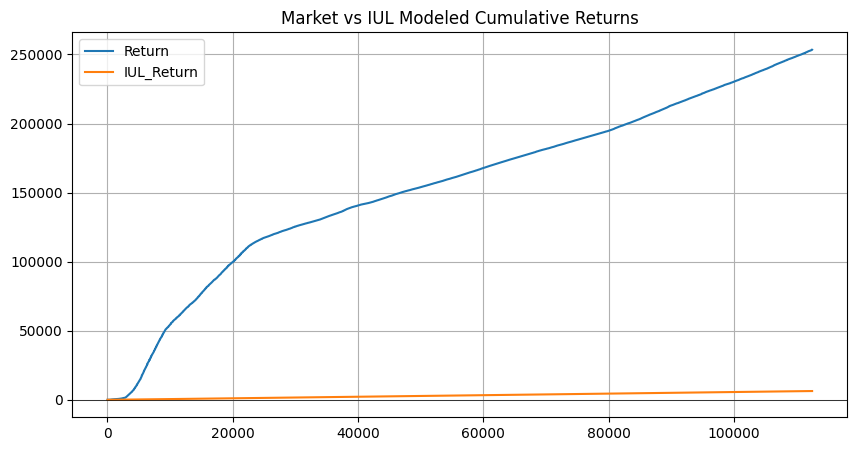

In [14]:
df[['Return', 'IUL_Return']].cumsum().plot(
    figsize=(10, 5),
    title='Market vs IUL Modeled Cumulative Returns'
)
plt.axhline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.show()
